In [1]:
# Import of the required libraries
import georinex as gr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as datetime
from datetime import datetime as dtt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

# Import of the software's modules
import functions as fn
import transformations as trf
import pointPositioning as pp
import RINEXreader 

In [2]:
# Definition of the paths to the RINEX files
nav_path = 'C:/Users/maria/OneDrive - Politecnico di Milano/Desktop/Tesi/mil21460/mil21460.21n'
obs_path = 'C:/Users/maria/OneDrive - Politecnico di Milano/Desktop/Tesi/mil21460/mil21460.21o'
eph_path = 'C:/Users/maria/OneDrive - Politecnico di Milano/Desktop/SAT_PP/dati/esa_eph_5min.sp3'

# Load with georinex library of nav and obs rinex info

In [3]:
# Loading of GPS navigation parameters from NAV RINEX
param_gps = gr.load(nav_path)
df_gps = param_gps.to_dataframe()
df_gps = ((df_gps.dropna()).sort_values(by=['time'], ascending = True)).reset_index()
# Corrupted timestamps are corrected
df_gps = fn.fixTime(df_gps)

# Loading of GPS code observations in a DataSet
obs = gr.load(obs_path, use = 'G')

C:\Users\maria\OneDrive - Politecnico di Milano\Desktop\SAT_PP\code_PointPositioning\functions.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'][i] = t


In [4]:
# Definition of time range in which we want to carry out the analysis (get Satellite position, velocity and clockoffset and
# perform Point Positioning)
time_range = []

START = df_gps['time'].min()
END = dtt.strptime('2021-05-26 23:45:00', '%Y-%m-%d %H:%M:%S')
t = START
while t <= END:
    time_range.append(t)
    t = t + datetime.timedelta(minutes=5)
mask_par = df_gps['time'] <= END
df_gps = df_gps[mask_par].reset_index().drop(columns=['index'])
    
# List of the timestamps of the available observation (we can perform Point Positioning only when we have sufficient 
# code observations)
time_obs = obs.time.to_dataframe()['time'].tolist()

# Satellites positions, velocities and clock offsets

In [5]:
# Definition of the empty DataFrame that will contain the results
satellites = pd.DataFrame(columns = ['time', 'sv', 'xs', 'ys', 'zs', 'xs_dot', 'ys_dot', 'zs_dot', 'ts', 'C1'])

for w in time_range:
    # The list of satellites, whose parameter we want to estimate, is obtained from the available observations:
    # for each instant of time in time_range we select the in-view satellite
    # their position, velocity and clock offset are the computed
    if w in time_obs:
        obs_tk = (obs.sel(time = w)).to_dataframe().reset_index()
        obs_tk = obs_tk[['time', 'sv', 'P1']].dropna().reset_index()
        available_sat = (obs_tk['sv']).to_list()
        if len(available_sat) > 0:
            for sv_i in available_sat:
                # Every satellite in view at the considered epoch is associated with the parameter slot 
                # to which it belongs through the getPar function
                sat_par = fn.getPar(sv_i, w, df_gps)
                # If the navigation parameters are available:
                if type(sat_par) == pd.core.frame.DataFrame:
                    sat = fn.satPosVel(sat_par).reset_index()
                    sat = sat.merge(obs_tk, on = ['sv', 'time'], how = 'left')
                    satellites = satellites.append(sat)
        
satellites = satellites.reset_index()
satellites = satellites[['time', 'sv', 'xs', 'ys', 'zs', 'xs_dot', 'ys_dot', 'zs_dot', 'ts', 'P1']]

print(satellites)

                    time   sv            xs            ys            zs  \
0    2021-05-26 00:00:00  G02  2.135798e+07 -1.473658e+07  6.439559e+06   
1    2021-05-26 00:00:00  G05  6.689723e+06 -1.392794e+07  2.143672e+07   
2    2021-05-26 00:00:00  G06  2.543621e+07 -5.896490e+06 -4.987166e+06   
3    2021-05-26 00:00:00  G07  1.425396e+07  1.027658e+07  2.040488e+07   
4    2021-05-26 00:00:00  G09  8.367914e+06  1.962441e+07  1.574966e+07   
...                  ...  ...           ...           ...           ...   
2754 2021-05-26 23:45:00  G06  2.570674e+07 -6.139753e+06 -2.894867e+06   
2755 2021-05-26 23:45:00  G07  1.576879e+07  9.699071e+06  1.957312e+07   
2756 2021-05-26 23:45:00  G09  8.744817e+06  1.828126e+07  1.709959e+07   
2757 2021-05-26 23:45:00  G16 -1.064216e+07  1.030792e+07  2.179147e+07   
2758 2021-05-26 23:45:00  G30  2.455321e+07  8.351522e+05  1.045232e+07   

           xs_dot       ys_dot       zs_dot        ts            P1  
0      768.788232   -80.19683

# Check on satellites' position and clock offsets

In [6]:
confronto = fn.checkSatPos(satellites, eph_path)

abs(computed_value - expected_value for ephemerides
Mean:
X:  0.8718309024030065
Y:  0.8402207830561448
Z:  0.7619525026546737
ts:  1.7294738646363538e-09
Max:
X:  3.4184254012070596
Y:  3.3884669207036495
Z:  3.1404189678141847
ts:  1.0673479164955216e-08


# Check on satellites' velocity

In [7]:
velocita = fn.checkSatVel(satellites, df_gps)

abs(computed_value - expected_value for velocities
Mean:
X:  0.29575239434822226
Y:  0.2418078877371472
Z:  0.4433721739124495
Max:
X:  0.5848334678478864
Y:  0.5844362541659507
Z:  0.7179177032536757


# Point Positioning

In [8]:
# Alpha and Beta paramethers for computing Ionosphere correction are read from nav RINEX through an apposite function
ionoParams = RINEXreader.getIonoParams(nav_path)
print('Inosphere parameters: ', ionoParams)

# Definition of the initial position of the receiver (from OBS RINEX)
R_0 = RINEXreader.getStartPos(obs_path)

# Performing of Point Positioning with the apposite function
results = pp.pointPositioning(satellites, R_0, ionoParams)

print(results)

Inosphere parameters:  [[6.5193e-09, 2.2352e-08, -5.9605e-08, -1.1921e-07], [86016.0, 98304.0, -65536.0, -524290.0]]
2021-05-26 00:00:00 ok
2021-05-26 00:05:00 ok
2021-05-26 00:10:00 ok
2021-05-26 00:15:00 ok
2021-05-26 00:20:00 ok
2021-05-26 00:25:00 ok
2021-05-26 00:30:00 ok
2021-05-26 00:35:00 ok
2021-05-26 00:40:00 ok
2021-05-26 00:45:00 ok
2021-05-26 00:50:00 ok
2021-05-26 00:55:00 ok
2021-05-26 01:00:00 ok
2021-05-26 01:05:00 ok
2021-05-26 01:10:00 ok
2021-05-26 01:15:00 ok
2021-05-26 01:20:00 ok
2021-05-26 01:25:00 ok
2021-05-26 01:30:00 ok
2021-05-26 01:35:00 ok
2021-05-26 01:40:00 ok
2021-05-26 01:45:00 ok
2021-05-26 01:50:00 ok
2021-05-26 01:55:00 ok
2021-05-26 02:00:00 ok
2021-05-26 02:05:00 ok
2021-05-26 02:10:00 ok
2021-05-26 02:15:00 ok
2021-05-26 02:20:00 ok
2021-05-26 02:25:00 ok
2021-05-26 02:30:00 ok
2021-05-26 02:35:00 ok
2021-05-26 02:40:00 ok
2021-05-26 02:45:00 ok
2021-05-26 02:50:00 ok
2021-05-26 02:55:00 ok
2021-05-26 03:00:00 ok
2021-05-26 03:05:00 ok
2021-05-2

In [9]:
print('Statistical analysis on Point Positioning results:')
print('Mean values: ')
print('XR: ', results['xr'].mean())
print('YR: ', results['yr'].mean())
print('ZR: ', results['zr'].mean())
print('dtR: ', results['dtr'].mean())

print('Standard deviation: ')
print('XR: ', results['xr'].std())
print('YR: ', results['yr'].std())
print('ZR: ', results['zr'].std())
print('dtR: ', results['dtr'].std())

Statistical analysis on Point Positioning results:
Mean values: 
XR:  4421978.922916769
YR:  718518.7213559577
ZR:  4524920.900447437
dtR:  3.5963614968969385e-06
Standard deviation: 
XR:  2.308868712046217
YR:  1.5035354723431846
ZR:  2.93712578402148
dtR:  0.0002675733443827068


# Transformation in Local Cartesian

In [10]:
# Coordinates of the receiver, Milan Permanent Station, reference: SPIN3GNSS
P0_g = [45.478368630552694, 9.229212872263435, 191.12520962953568]
P0_cart = trf.geodToCart(45.478368630552694, 9.229212872263435, 191.12520962953568)

results_LC = pd.DataFrame()
results_LC['dx'] = results['xr'] - P0_cart[0]
results_LC['dy'] = results['yr'] - P0_cart[1]
results_LC['dz'] = results['zr'] - P0_cart[2]

E=[]
N=[]
U=[]

lat0 = trf.degToRad(P0_g[0])
lon0 = trf.degToRad(P0_g[1])

# Definition of the rotation matrix
R = np.array([ [-np.sin(lon0), np.cos(lon0), 0],
                [-np.sin(lat0)*np.cos(lon0), -np.sin(lat0)*np.sin(lon0), np.cos(lat0)],
                [np.cos(lat0)*np.cos(lon0), np.cos(lat0)*np.sin(lon0), np.sin(lat0)]
                ])

for i in range(len(results_LC)):
    delta_array_i = np.array([[results_LC['dx'][i]], [results_LC['dy'][i]], [results_LC['dz'][i]]])
    ENU =np.dot(R, delta_array_i)
    E.append(ENU[0][0])
    N.append(ENU[1][0])
    U.append(ENU[2][0])

results_LC['E'] = E
results_LC['N'] = N
results_LC['U'] = U
results_LC['time'] = results['datetime']
results_LC = results_LC.reset_index()

In [17]:
print('MEDIA ERRORI:')
print('Est: ', results_LC['E'].mean(), '\n',
      'Nord: ', results_LC['N'].mean(), '\n',
      'Quota: ', results_LC['U'].mean() )

print('DEVIAZIONE STANDARD:', '\n',
      'Est: ', results_LC['E'].std(), '\n',
      'Nord: ', results_LC['N'].std(), '\n',
      'Quota: ', results_LC['U'].std() )

print('Valori Massimi:', '\n',
      'Est: ', abs(results_LC['E']).max(), '\n',
      'Nord: ', abs(results_LC['N']).max(), '\n',
      'Quota: ', abs(results_LC['U']).max() )

MEDIA ERRORI:
Est:  0.4818059998588536 
 Nord:  1.7714432327072114 
 Quota:  -0.5748367987282187
DEVIAZIONE STANDARD: 
 Est:  1.4534375655775489 
 Nord:  2.253763014689167 
 Quota:  3.0043756479194146
Valori Massimi: 
 Est:  4.867525575042814 
 Nord:  8.67494786378046 
 Quota:  8.33405731281589


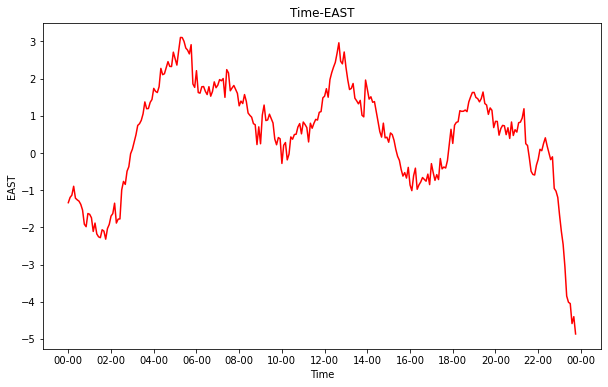

In [12]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(results_LC['time'], results_LC['E'],
        '-',
        color='red')
ax.set(xlabel="Time", ylabel='EAST', title = 'Time-EAST')
ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%H-%M"))
plt.show()

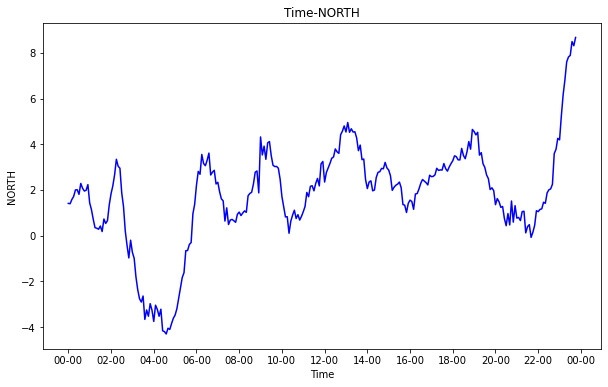

In [13]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(results_LC['time'], results_LC['N'],
        '-',
        color='blue')
ax.set(xlabel="Time", ylabel='NORTH', title = 'Time-NORTH')
ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%H-%M"))
plt.show()

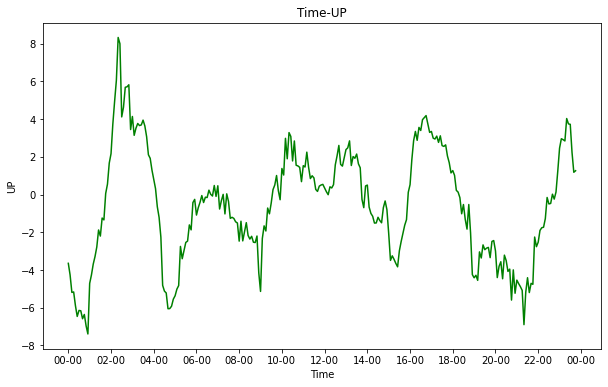

In [14]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(results_LC['time'], results_LC['U'],
        '-',
        color='green')
ax.set(xlabel="Time", ylabel='UP', title = 'Time-UP')
ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%H-%M"))
plt.show()